# Linear Classifier

Before we start, run the following magic sauce to install the required Julia packages and check that we're good to go.

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
println("Excellent! Everything is good to go!")

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Excellent! Everything is good to go!


### For this class we are going to use a dataset of breast tumours. 

In [2]:
using JuMP, GLPK, CSV, Plots

#Read data from
data_tumors = CSV.read("data_tumors.csv", header = false)

┌ Info: Recompiling stale cache file /Users/guilhermebodin/.julia/compiled/v1.0/JuMP/DmXqY.ji for JuMP [4076af6c-e467-56ae-b986-b466b2749572]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /Users/guilhermebodin/.julia/compiled/v1.0/GLPK/r6CoY.ji for GLPK [60bf3e95-4087-53dc-ae20-288a0d20c6a6]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /Users/guilhermebodin/.julia/compiled/v1.0/CSV/HHBkp.ji for CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /Users/guilhermebodin/.julia/compiled/v1.0/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1190


,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,Column10,Column11,Column12,Column13,Column14,Column15,Column16,Column17,Column18,Column19,Column20,Column21,Column22,Column23,Column24,Column25,Column26,Column27,Column28,Column29,Column30,Column31,Column32
,Int64⍰,String⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰
1,842302,M,17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,1.095,0.9053,8.589,153.4,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189
2,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.0186,0.0134,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.186,0.275,0.08902
3,84300903,M,19.69,21.25,130.0,1203.0,0.1096,0.1599,0.1974,0.1279,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.00615,0.04006,0.03832,0.02058,0.0225,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.243,0.3613,0.08758
4,84348301,M,11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414,0.1052,0.2597,0.09744,0.4956,1.156,3.445,27.23,0.00911,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.5,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.173
5,84358402,M,20.29,14.34,135.1,1297.0,0.1003,0.1328,0.198,0.1043,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.01149,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.2,1575.0,0.1374,0.205,0.4,0.1625,0.2364,0.07678
6,843786,M,12.45,15.7,82.57,477.1,0.1278,0.17,0.1578,0.08089,0.2087,0.07613,0.3345,0.8902,2.217,27.19,0.00751,0.03345,0.03672,0.01137,0.02165,0.005082,15.47,23.75,103.4,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.1244
7,844359,M,18.25,19.98,119.6,1040.0,0.09463,0.109,0.1127,0.074,0.1794,0.05742,0.4467,0.7732,3.18,53.91,0.004314,0.01382,0.02254,0.01039,0.01369,0.002179,22.88,27.66,153.2,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368
8,84458202,M,13.71,20.83,90.2,577.9,0.1189,0.1645,0.09366,0.05985,0.2196,0.07451,0.5835,1.377,3.856,50.96,0.008805,0.03029,0.02488,0.01448,0.01486,0.005412,17.06,28.14,110.6,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.1151
9,844981,M,13.0,21.82,87.5,519.8,0.1273,0.1932,0.1859,0.09353,0.235,0.07389,0.3063,1.002,2.406,24.32,0.005731,0.03502,0.03553,0.01226,0.02143,0.003749,15.49,30.73,106.2,739.3,0.1703,0.5401,0.539,0.206,0.4378,0.1072


### About this dataset

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. n the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

This database is also available through the UW CS ftp server: ftp ftp.cs.wisc.edu cd math-prog/cpo-dataset/machine-learn/WDBC/

Also can be found on UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

Attribute Information:

1) ID number 2) Diagnosis (M = malignant, B = benign) 3-32)

Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter) b) texture (standard deviation of gray-scale values) c) perimeter d) area e) smoothness (local variation in radius lengths) f) compactness (perimeter^2 / area - 1.0) g) concavity (severity of concave portions of the contour) h) concave points (number of concave portions of the contour) i) symmetry j) fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

Missing attribute values: none

Class distribution: 357 benign, 212 malignant

| Columun | Attribute name | Description| 
|:---:|:---:|:---:|
|1 |id |ID number|
|2 |diagnosis| The diagnosis of breast tissues (M = malignant, B = benign)|
|3 |radius_mean| mean of distances from center to points on the perimeter|
|4 |texture_mean| standard deviation of gray-scale values|
|5 |perimeter_mean| mean size of the core tumor|
|6 |area_mean|-|
|7 |smoothness_mean| mean of local variation in radius lengths|
|8 |compactness_mean| mean of perimeter^2 / area - 1.0|
|9 |concavity_mean| mean of severity of concave portions of the contour|
|10 |concave points_mean| mean for number of concave portions of the contour|
|11 |symmetry_mean|-|
|12 |fractal_dimension_mean| mean for "coastline approximation" - 1|
|13 |radius_se| standarderror for the mean of distances from center to points on the perimeter|
|14 |texture_se| standarderror for standard deviation of gray-scale values|
|15 |perimeter_se|-|
|16 |area_se|-|
|17 |smoothness_se| standarderror for local variation in radius lengths|
|18 |compactness_se| standarderror for perimeter^2 / area - 1.0|
|19 |concavity_se |standarderror for severity of concave portions of the contour|
|20 |concave points_se| standarderror for number of concave portions of the contour|
|21 |symmetry_se|-|
|22 |fractal_dimension_se| standarderror for "coastline approximation" - 1|
|23 |radius_worst| "worst" or largest mean value for mean of distances from center to points on the perimeter|
|24 |texture_worst| "worst" or largest mean value for standard deviation of gray-scale values|
|25 |perimeter_worst|-|
|26 |area_worst|-|
|27 |smoothness_worst| "worst" or largest mean value for local variation in radius lengths|
|28 |compactness_worst| "worst" or largest mean value for perimeter^2 / area - 1.0|
|29 |concavity_worst| "worst" or largest mean value for severity of concave portions of the contour|
|30 |concave points_worst | "worst" or largest mean value for number of concave portions of the contour|
|31 |symmetry_worst| -|
|32 |fractal_dimension_worst | "worst" or largest mean value for "coastline approximation" - 1|


Here we are going to separate the data in a clever way to do the linear classifier

In [3]:
num_attributes = 30
train_set_size = 400

train_set_attrs = convert(Matrix{Float64}, data_tumors[1:train_set_size, 3:end])
train_set_diagnosis = convert(Vector{String}, data_tumors[1:train_set_size, 2])

test_set_attrs = convert(Matrix{Float64}, data_tumors[train_set_size + 1:end, 3:end])
test_set_diagnosis = convert(Vector{String}, data_tumors[train_set_size + 1:end, 2])

169-element Array{String,1}:
 "M"
 "B"
 "B"
 "B"
 "B"
 "B"
 "B"
 "B"
 "M"
 "B"
 "B"
 "B"
 "B"
 ⋮  
 "B"
 "B"
 "B"
 "B"
 "B"
 "M"
 "M"
 "M"
 "M"
 "M"
 "M"
 "B"

Let's see the first two attributes

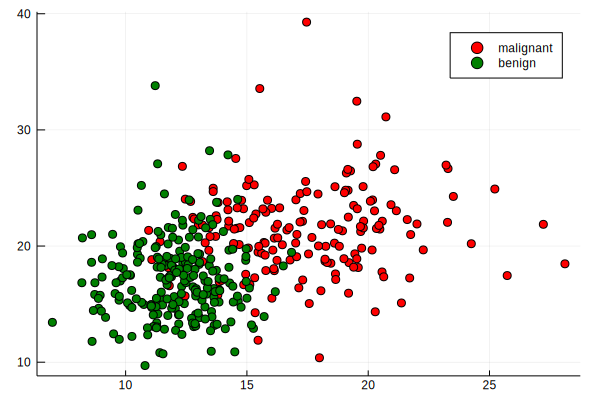

In [4]:
function plotattributes(train_set_attrs, train_set_diagnosis, attrs::Vector{Int})
    if length(attrs) > 2
        error("Only two attributes at each time are allowed")
    end

    idx_M = findall(x -> x == "M", train_set_diagnosis)
    idx_B = findall(x -> x == "B", train_set_diagnosis)

    p1 = scatter(train_set_attrs[idx_M, attrs[1]], train_set_attrs[idx_M, attrs[2]], color = "red", label = "malignant")
    scatter!(p1, train_set_attrs[idx_B, attrs[1]], train_set_attrs[idx_B, attrs[2]], color = "green", label = "benign")

    return p1
end

plotattributes(train_set_attrs, train_set_diagnosis, [1;2])

Now let's try to make a linear classifier in this data. As described in Bertsimas linear optimization book, we will consider the model.

$$
\begin{align}
%
\min_{x_j \geq 0, c \geq 0} & \quad \sum_i \epsilon_i\\
%
\mbox{s.t.: } & \nonumber \\
& a_{ij}x_{j} + c \geq -\epsilon \quad \forall i \in Benign \quad \forall j \in 1 \dots numattributes \\
& a_{ij}x_{j} + c \leq \epsilon - 1 \quad \forall i \in Malignant \quad \forall j \in 1 \dots numattributes \\
%
\end{align}
$$

For the first model let's try to make the linear separator with the 2 first attributes (radius_mean, texture_mean)

In [5]:
m = Model(with_optimizer(GLPK.Optimizer))
n = 2
@variable(m, x[i = 1:n])
@variable(m, c)
@variable(m, ϵ[i = 1:train_set_size] >= 0)

for i in 1:train_set_size
    if train_set_diagnosis[i] == "M"
        @constraint(m, sum(train_set_attrs[i, j]*x[j] for j in 1:n) + c >= -ϵ[i])
    elseif train_set_diagnosis[i] == "B"
        @constraint(m, sum(train_set_attrs[i, j]*x[j] for j in 1:n) + c <= ϵ[i] - 1)
    end
end

@objective(m, Min, sum(ϵ))

optimize!(m)

x = value.(x)
c = value.(c)
obj_val = objective_value(m)

51.987268518518476

Can we see this linear separator? Of course!

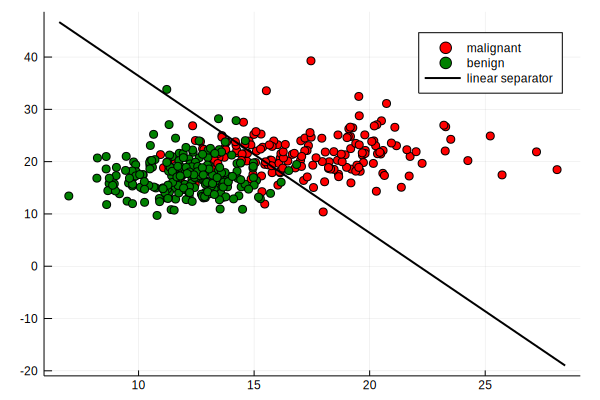

In [6]:
function plotattributes_classifier(train_set_attrs, train_set_diagnosis, attrs::Vector{Int}, x, c)
    if length(attrs) > 2
        error("Only two attributes at each time are allowed")
    end

    idx_M = findall(x -> x == "M", train_set_diagnosis)
    idx_B = findall(x -> x == "B", train_set_diagnosis)

    p1 = scatter(train_set_attrs[idx_M, attrs[1]], train_set_attrs[idx_M, attrs[2]], color = "red", label = "malignant")
    scatter!(p1, train_set_attrs[idx_B, attrs[1]], train_set_attrs[idx_B, attrs[2]], color = "green", label = "benign")

    f(y) = (-(x[1]*y/x[2]) - c/x[2])
    plot!(p1, f, label = "linear separator", color = "black", width = 2)

    return p1
end

plotattributes_classifier(train_set_attrs[:, 1:2], train_set_diagnosis, [1;2], x, c)

One way of analysing this results is by visualizing the [Confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)

In [7]:
function confusion_matrix_result(set_attrs, set_diagnosis, x, c)
    set_size, num_attributes = size(set_attrs)
    result = zeros(2, 2)
    for i = 1:set_size
        if sum(set_attrs[i, j]*x[j] for j = 1:num_attributes) + c >= 0
            classification = "M"
        else
            classification = "B"
        end
        if classification == "M" && set_diagnosis[i] == "B"
            result[1, 2] += 1
        elseif classification == "B" && set_diagnosis[i] == "M"
            result[2, 1] += 1
        elseif classification == "B" && set_diagnosis[i]  == "B"
            result[1, 1] += 1
        elseif classification == "M" && set_diagnosis[i]  == "M"
            result[2, 2] += 1
        end
    end
    return result
end

confusion_matrix_result(train_set_attrs[:, 1:2], train_set_diagnosis, x, c)
confusion_matrix_result(test_set_attrs[:, 1:2], test_set_diagnosis, x, c)

2×2 Array{Float64,2}:
 118.0  12.0
   5.0  34.0

Now let's try with all attributes

In [8]:
m = Model(with_optimizer(GLPK.Optimizer))

n = num_attributes
@variable(m, x[i = 1:n])
@variable(m, c)
@variable(m, ϵ[i = 1:train_set_size] >= 0)

for i in 1:train_set_size
    if train_set_diagnosis[i] == "M"
        @constraint(m, sum(train_set_attrs[i, j]*x[j] for j in 1:n) + c >= -ϵ[i])
    elseif train_set_diagnosis[i] == "B"
        @constraint(m, sum(train_set_attrs[i, j]*x[j] for j in 1:n) + c <= ϵ[i] - 1)
    end
end

@objective(m, Min, sum(ϵ))

optimize!(m)

x = value.(x)
c = value.(c)
obj_val = objective_value(m)

0.0

Let's see the confusion matrix of the training set and the test set. Note that un the trainning set the tumours were separted perfectly! :) 

The false positives and false negatives sum 0! Unfortunately we did not manage to get the same results in our test set, one way of approaching this problem is by using regularization.

In [9]:
@show confusion_matrix_result(train_set_attrs, train_set_diagnosis, x, c)
@show confusion_matrix_result(test_set_attrs, test_set_diagnosis, x, c)

confusion_matrix_result(train_set_attrs, train_set_diagnosis, x, c) = [227.0 0.0; 0.0 173.0]
confusion_matrix_result(test_set_attrs, test_set_diagnosis, x, c) = [122.0 8.0; 2.0 37.0]


2×2 Array{Float64,2}:
 122.0   8.0
   2.0  37.0

## Regularization

[Regularization](https://bit.ly/2TwPRvr) is mainly used to prevent models to [overfit](https://en.wikipedia.org/wiki/Overfitting) the data. There are many ways to add regularization o a model but as we are interested in linear programming approaches we are going to use L1 regularization also known as [Lasso](https://en.wikipedia.org/wiki/Lasso_(statistics)). 

The Lasso method have some really nice properties, one of them is making the lots of unecessary attributes equal to 0. This mean that we can predict if the tumours if either malignant or benign with fewer attributes, and two benefits immediately arise:

* If a parameter does not help us determine the nature of the tumour we should just stop measuring it and save some time and money
* The model can be better interpreted, it is way easier to understand the effects of 5 variables than to understand the effects of 30 variables

So now it's your turn! 

Write a function that receives the trainning set, and a regularization parameter $\lambda$ and solve the model below

$$
\begin{align}
%
\min_{x_j \geq 0, c \geq 0} & \quad (1-\lambda)\sum_i \epsilon_i + \lambda(\sum_j (|x_j|) + |c|)\\
%
\mbox{s.t.: } & \nonumber \\
& a_{ij}x_{j} + c \geq -\epsilon \quad \forall i \in Benign \quad \forall j \in 1 \dots numattributes \\
& a_{ij}x_{j} + c \leq \epsilon - 1 \quad \forall i \in Malignant \quad \forall j \in 1 \dots numattributes \\
%
\end{align}
$$

Remenber that you must do some trick to model absolute values in a linear programming application.

After writing the function you should answer 3 questions, for both questions you should only use the training set to fit your model:

1. Using `λ = 0:0.01:1` which one gives us the lowest error? In this case we measure error as the sum of false positives and false negatives for the training and test sets.
2. How many attributes are different than 0 for the `λ` found on the first question, how many attributes are different than 0 for `λ = 0.04`?
3. How is the shape of the plot of the objective value x `λ`. Is it convex, concave, affine, non-convex? Why this happens?

In [10]:
function regularized_linear_classifier(train_set_attrs, train_set_diagnosis, λ::Number)
    m = Model(with_optimizer(GLPK.Optimizer))

    train_set_size = size(train_set_attrs, 1)
    num_attributes = size(train_set_attrs, 2)
    
    #TODO

    stauts = optimize!(m)

    obj_val = objective_value(m)
    x = value.(x_plus) .- value.(x_minus)
    c = value.(c_plus) .- value.(c_minus)

    return obj_val, x, c
end

regularized_linear_classifier (generic function with 1 method)

In [11]:
# Here I made a very simple script to help you find you answers

obj_val_vec = Float64[]
for λ = 0:0.01:1
    obj_val, x, c = regularized_linear_classifier(train_set_attrs, train_set_diagnosis, λ)
    train_matrix = confusion_matrix_result(train_set_attrs, train_set_diagnosis, x, c)
    test_matrix = confusion_matrix_result(test_set_attrs, test_set_diagnosis, x, c)
    push!(obj_val_vec, obj_val)
    @show train_matrix[1,2] + train_matrix[2,1] + test_matrix[1,2] + test_matrix[2,1]
    @show λ
end
obj_val, x_0, c = regularized_linear_classifier(train_set_attrs, train_set_diagnosis, 0)
obj_val, x_004, c = regularized_linear_classifier(train_set_attrs, train_set_diagnosis, 0.04)
@show count(x_0 .!= 0)
@show count(x_004 .!= 0)
plot(obj_val_vec)

glp_add_cols: ncs = 0; invalid number of columns
Error detected in file api/prob1.c at line 362


GLPKFatalError: GLPKFatalError("GLPK call failed. All GLPK objects you defined so far are now invalidated.")

## If you want to do this homework using a notebook your answers should go here